### 1. Install Dependencies, Import required Libraries and authenticate with Earth engine

In [1]:
!pip install geemap


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from os.path import isfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import geemap
from geemap import ml
import ee
# from google.colab import drive

In [3]:
geemap.ee_initialize()

## 2. Data Extraction:

* Extract Training and Validation data from Drive
* Sample x-y points uniformly from dataset
* Store it in `x_train, y_train, x_test, y_test` for train and validating the model

In [3]:
# drive.mount('/content/gdrive')
gdrive_pref = ''

Compute the names of folders to be used

In [5]:
folder_pref = './AEZ_datasets_train_'
areas = np.arange(5,7)
folders = np.char.add(folder_pref, areas.astype(str))
print(folders)

['./AEZ_datasets_train_5' './AEZ_datasets_train_6']


Using the naming convention compute the names of the files to be used:

In [6]:
years = np.arange(2016, 2023)
seasons = np.array(['Rabi_1','Kharif_1','Zaid_1'])
filenames = np.array([])
for year in years:
    for season in seasons:
        filenames = np.append(filenames, str(year) + '_' + season)
print(filenames)

['2016_Rabi_1' '2016_Kharif_1' '2016_Zaid_1' '2017_Rabi_1' '2017_Kharif_1'
 '2017_Zaid_1' '2018_Rabi_1' '2018_Kharif_1' '2018_Zaid_1' '2019_Rabi_1'
 '2019_Kharif_1' '2019_Zaid_1' '2020_Rabi_1' '2020_Kharif_1' '2020_Zaid_1'
 '2021_Rabi_1' '2021_Kharif_1' '2021_Zaid_1' '2022_Rabi_1' '2022_Kharif_1'
 '2022_Zaid_1']


Append the file names paths to the dataset_paths array

In [7]:
dataset_paths = np.array([])
for folder in folders:
    for filename in filenames:
        dataset_paths = np.append(dataset_paths, gdrive_pref+folder + '/' + filename + '.csv')
        print(dataset_paths[-1])

./AEZ_datasets_train_5/2016_Rabi_1.csv
./AEZ_datasets_train_5/2016_Kharif_1.csv
./AEZ_datasets_train_5/2016_Zaid_1.csv
./AEZ_datasets_train_5/2017_Rabi_1.csv
./AEZ_datasets_train_5/2017_Kharif_1.csv
./AEZ_datasets_train_5/2017_Zaid_1.csv
./AEZ_datasets_train_5/2018_Rabi_1.csv
./AEZ_datasets_train_5/2018_Kharif_1.csv
./AEZ_datasets_train_5/2018_Zaid_1.csv
./AEZ_datasets_train_5/2019_Rabi_1.csv
./AEZ_datasets_train_5/2019_Kharif_1.csv
./AEZ_datasets_train_5/2019_Zaid_1.csv
./AEZ_datasets_train_5/2020_Rabi_1.csv
./AEZ_datasets_train_5/2020_Kharif_1.csv
./AEZ_datasets_train_5/2020_Zaid_1.csv
./AEZ_datasets_train_5/2021_Rabi_1.csv
./AEZ_datasets_train_5/2021_Kharif_1.csv
./AEZ_datasets_train_5/2021_Zaid_1.csv
./AEZ_datasets_train_5/2022_Rabi_1.csv
./AEZ_datasets_train_5/2022_Kharif_1.csv
./AEZ_datasets_train_5/2022_Zaid_1.csv
./AEZ_datasets_train_6/2016_Rabi_1.csv
./AEZ_datasets_train_6/2016_Kharif_1.csv
./AEZ_datasets_train_6/2016_Zaid_1.csv
./AEZ_datasets_train_6/2017_Rabi_1.csv
./AEZ_dat

Append the relevant filenames to train-path array and val-path array

In [13]:
train_data_path = np.array([])
val_data_path = np.array([])
for dataset_path in dataset_paths:
    year = dataset_path.split('/')[2].split('_')[0]
    train_area = int(dataset_path.split('/')[1].split('_')[3])
    # print(train_area)
    if(int(year) == 2022):
        val_data_path = np.append(val_data_path, dataset_path)
    else:
        train_data_path = np.append(train_data_path, dataset_path)
# print(train_data_path)

Extract headers from the first file

In [9]:
headers = np.array(pd.read_csv(train_data_path[0]).columns)

Extract the data from the files and store in train_data and val_data


In [14]:
train_data = np.array([])
for data_path in train_data_path:
    if(isfile(data_path)):
        data = pd.read_csv(data_path)
        data = np.array(data)
        if(train_data.size == 0):
            train_data = data
        else:
            train_data = np.vstack((train_data, data))
    else:
        print(data_path + ' does not exist')
print(train_data.shape)


(73817, 28)


In [15]:
val_data = np.array([])
for data_path in val_data_path:
    if(isfile(data_path)):
        data = pd.read_csv(data_path)
        data = np.array(data)
        if(val_data.size == 0):
            val_data = data
        else:
            val_data = np.vstack((val_data, data))
    else:
        print(data_path + ' does not exist')
print(val_data.shape)

(7304, 28)


Remove features containing nan values, to find the corrupt headers

In [16]:
indices = np.argwhere(np.isnan(train_data))
indices = np.unique(indices[:, 1])
print(indices)

corrupt_headers = headers[indices]
print(corrupt_headers)

indix = np.argwhere(np.isnan(val_data))
indix = np.unique(indix[:, 1])

train_data = np.delete(train_data, indices, 1)
val_data = np.delete(val_data, indix, 1)

# output the size of the train_data and val_data

print(train_data.shape)
print(val_data.shape)


[20]
['lw']
(73817, 27)
(7304, 27)


Extract labels and feature names (required for converting random forest regressor to strings)

In [17]:
labels = headers[-1]
feature_names = np.array([])
for header in headers[:-1]:
    if header not in corrupt_headers:
        feature_names = np.append(feature_names, header)
print(feature_names)
print(len(feature_names))
print(labels)

['MSAVI' 'NDMI' 'NDVI' 'NDWI' 'SAVI' 'NDBI' 'NDIIB7' 'ALBEDO' 'LST'
 'humid' 'rain' 'temp' 'psurf' 'canopy' 'sm' 'wind' 'root' 'soiltemp'
 'runoff' 'sw' 'qle' 'qh' 'qg' 'swnet' 'lwnet' 'tair']
26
ET


Extract the train_data_x, train_data_y, val_data_x, val_data_y from train_data and val_data

In [18]:
train_data_x = train_data[:, :-1]
train_data_y = train_data[:, -1]/8

val_data_x = val_data[:, :-1]
val_data_y = val_data[:, -1]/8

RUN THIS CELL IF THERE IS STORAGE ISSUE, THIS WILL DELETE UNNECESSARY VARIABLES THAT WOULD NOT BE REQUIRED IN FURTHER CELLS

In [19]:
del train_data
del val_data
del folder_pref
del areas
del folders
del years
del seasons
del filenames
del dataset_paths
del train_data_path
del val_data_path

PURE TRAIN DATA (SAMPLE RANDOMLY N POINTS FOR TRAINING AND STORE IN x_train AND y_train):

In [20]:
N = 150000

shuffle_indices = np.arange(train_data_x.shape[0])
np.random.shuffle(shuffle_indices)
train_x = train_data_x[shuffle_indices]
train_y = train_data_y[shuffle_indices]
x_train = train_x[:N]
y_train = train_y[:N]

#verify the size of y_train
print(len(y_train))

73817


 PURE VALIDATION DATA (SAMPLE RANDOMLY M POINTS FOR VALIDATION AND STORE IN x_test AND y_test):


In [21]:
N = 10000
shuffle_indices = np.arange(val_data_x.shape[0])

np.random.shuffle(shuffle_indices)
val_x = val_data_x[shuffle_indices]
val_y = val_data_y[shuffle_indices]
x_test = val_x[:N]
y_test = val_y[:N]

## 3. Train and Assess the model
* Train `rf_model` on x_train, y_train (train data points)
* Get the predictions for train and test data
* Output different metrics on these predictions such as `rmse, nrmse, R2_score`
* Plot the scatter plots of true values v/s predicted values

Use Random Forest Regressor (change the parameters as required) and store the model in rf_model

In [22]:

rf_model = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=50,n_jobs=-1)
rf_model.fit(x_train, y_train)


RandomForestRegressor(max_depth=10, n_estimators=50, n_jobs=-1, random_state=0)

In [23]:
y_pred = rf_model.predict(x_test)           # predict the values of y_test using the model (validation output stored in y_pred)
# y_pred_train = rf_model.predict(x_train)    # predict the values of y_train using the model (training output stored in y_pred_train)

Compute the metrics for the model (mse, rmse, nrmse, nmse)

In [24]:
testsize = x_test.shape[0]
print(f'Test size: {testsize}')
mse = mean_squared_error(y_test, y_pred)
mse0 = mean_squared_error(y_test, np.zeros(testsize))
ymean = np.mean(y_pred)

print(f'mean of pred: {ymean}')
print(f'mse: {mse}')
rmse = np.sqrt(mse)
print(f'rmse: {rmse}')
print(f'nmse: {mse/mse0}')
nrmse = rmse/ymean
print(f'nrmse: {nrmse}')
print(ymean)

Test size: 7304
mean of pred: 11.489648027045305
mse: 21.344697206566053
rmse: 4.620032165100807
nmse: 0.074271146821241
nrmse: 0.4021038898864251
11.489648027045305


Compute R2 score of the model on Train and Validation data

In [222]:

r2_train = r2_score(y_train, y_pred_train)
print(f'r2_train: {r2_train}')

r2_val = r2_score(y_test, y_pred)
print(f'r2_validation: {r2_val}')

r2_train: 0.8653424758960057
r2_validation: 0.7585583504562731


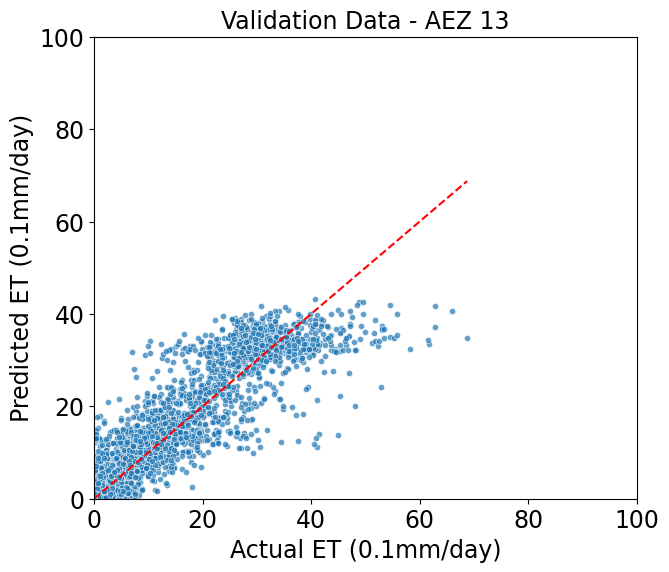

In [223]:
y_actual = y_test
aez = 13
set_fontsize = 17

# subfigure of size 2x1
plt.figure(figsize=(7, 6))
# plt.subplot(1, 2, 1)

plt.scatter(y_actual, y_pred, s=20, alpha=0.7, edgecolors='w', linewidth=0.5)

# Plot the 45-degree line
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')

# Set axis labels
plt.xlim(0,100)
plt.ylim(0,100)
plt.xticks(fontsize=set_fontsize)
plt.yticks(fontsize=set_fontsize)
plt.xlabel('Actual ET (0.1mm/day)', fontsize=set_fontsize)
plt.ylabel('Predicted ET (0.1mm/day)', fontsize = set_fontsize)

# Set plot title
# plt.title(f'Training Data', fontsize=set_fontsize)
# plt.savefig(f'Training_multi.png', bbox_inches='tight')

# plt.subplot(1, 2, 2)

# y_actual = y_test

# plt.scatter(y_actual, y_pred, s=20, alpha=0.7, edgecolors='w', linewidth=0.5)

# # Plot the 45-degree line
# plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')

# # Set axis labels
# plt.xlim(0,100)
# plt.ylim(0,100)
# plt.xticks(fontsize=set_fontsize)
# plt.yticks(fontsize=set_fontsize)
# plt.xlabel('Actual ET (0.1mm/day)', fontsize=set_fontsize)
# # plt.ylabel('Predicted ET (0.1mm/day)', fontsize = set_fontsize)

# # Set plot title
plt.title(f'Validation Data - AEZ {aez}', fontsize=set_fontsize)

plt.savefig(f'AEZ{aez}_multi.png', bbox_inches='tight')
# # Show the plot
# plt.show()

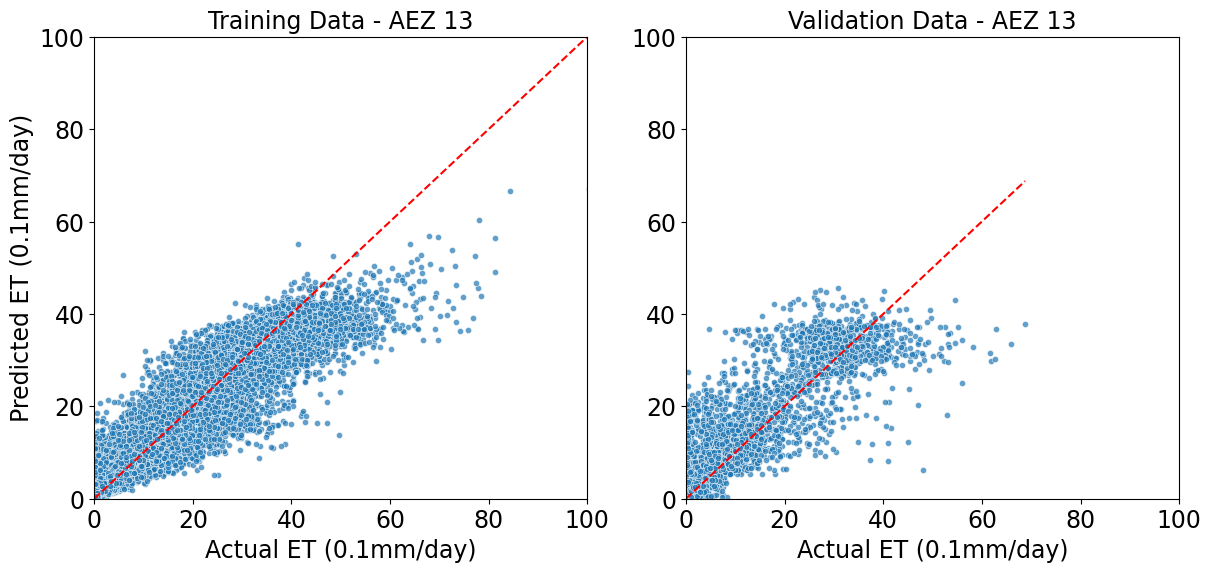

In [139]:
y_actual = y_train
aez = 13
set_fontsize = 17

# subfigure of size 2x1
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)


plt.scatter(y_actual, y_pred_train, s=20, alpha=0.7, edgecolors='w', linewidth=0.5)

# Plot the 45-degree line
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')

# Set axis labels
plt.xlim(0,100)
plt.ylim(0,100)
plt.xticks(fontsize=set_fontsize)
plt.yticks(fontsize=set_fontsize)
plt.xlabel('Actual ET (0.1mm/day)', fontsize=set_fontsize)
plt.ylabel('Predicted ET (0.1mm/day)', fontsize = set_fontsize)

# Set plot title
plt.title(f'Training Data - AEZ {aez}', fontsize=set_fontsize)

plt.subplot(1, 2, 2)

y_actual = y_test

plt.scatter(y_actual, y_pred, s=20, alpha=0.7, edgecolors='w', linewidth=0.5)

# Plot the 45-degree line
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')

# Set axis labels
plt.xlim(0,100)
plt.ylim(0,100)
plt.xticks(fontsize=set_fontsize)
plt.yticks(fontsize=set_fontsize)
plt.xlabel('Actual ET (0.1mm/day)', fontsize=set_fontsize)
# plt.ylabel('Predicted ET (0.1mm/day)', fontsize = set_fontsize)

# Set plot title
plt.title(f'Validation Data - AEZ {aez}', fontsize=set_fontsize)

plt.savefig(f'AEZ{aez}_single.png', bbox_inches='tight')
# Show the plot
plt.show()

In [267]:
region_paths = ['od', 'raj', 'mp', 'chhat', 'jamui']
years = '/2022_Zaid_1.csv'
lulc = 'crop'
lulc_paths = np.array([])
for region_path in region_paths:
    lulc_paths = np.append(lulc_paths, gdrive_pref + './LULC_'+ lulc + '_' + region_path + years)
    print(lulc_paths[-1])

./LULC_crop_od/2022_Zaid_1.csv
./LULC_crop_raj/2022_Zaid_1.csv
./LULC_crop_mp/2022_Zaid_1.csv
./LULC_crop_chhat/2022_Zaid_1.csv
./LULC_crop_jamui/2022_Zaid_1.csv


In [268]:
test_data_lulc = np.array([])
for lulc_path in lulc_paths:
    if(isfile(lulc_path)):
        data = pd.read_csv(lulc_path)
        data = np.array(data)
        if(test_data_lulc.size == 0):
            test_data_lulc = data
        else:
            test_data_lulc = np.vstack((test_data_lulc, data))
    else:
        print(lulc_path + ' does not exist')

In [269]:
x_test = test_data_lulc[:, :-1]
y_test = test_data_lulc[:, -1]/8
print(x_test.shape)
print(y_test.shape)
# indix = np.argwhere(np.isnan(x_test))
# x_test = np.delete(x_test, indices, 1)
# filter out only points with y value > 20
# indices_2 = np.argwhere(y_test < 8)
# x_test = np.delete(x_test, indices_2, 0)
# y_test = np.delete(y_test, indices_2, 0)
# indices_2 = np.argwhere(y_test > 35)
# x_test = np.delete(x_test, indices_2, 0)
# y_test = np.delete(y_test, indices_2, 0)

shuffle_indices = np.arange(x_test.shape[0])
np.random.shuffle(shuffle_indices)
x_test = x_test[shuffle_indices]
y_test = y_test[shuffle_indices]
x_test = x_test[:300]
y_test = y_test[:300]

print(x_test.shape)
print(y_test.shape)

(304, 27)
(304,)
(300, 27)
(300,)


In [ ]:
seasons = ['1', '2', '3', '4']
year = '2022'
folder = './Shrubs/'
dataset_paths = []
for s in seasons:
    dataset_paths.append(gdrive_pref + folder + year + '_' + s + '.csv')
print(dataset_paths)
data = np.array([])
for data_path in dataset_paths:
    if(isfile(data_path)):
        data = pd.read_csv(data_path)
        data = np.array(data)
        if(data.size == 0):
            data = data
        else:
            data = np.vstack((data, data))
            
print(data.shape)
bbsr_data_path = gdrive_pref + './bbsr_buildup_1.csv'
bbsr_data = pd.read_csv(bbsr_data_path)
bbsr_data = np.array(bbsr_data)
x_test = bbsr_data[:, :-1]
y_test = bbsr_data[:, -1]/8
x_test = np.delete(x_test, indices, 1)
print(x_test.shape)


#### Plots for Accuracy Assessment:

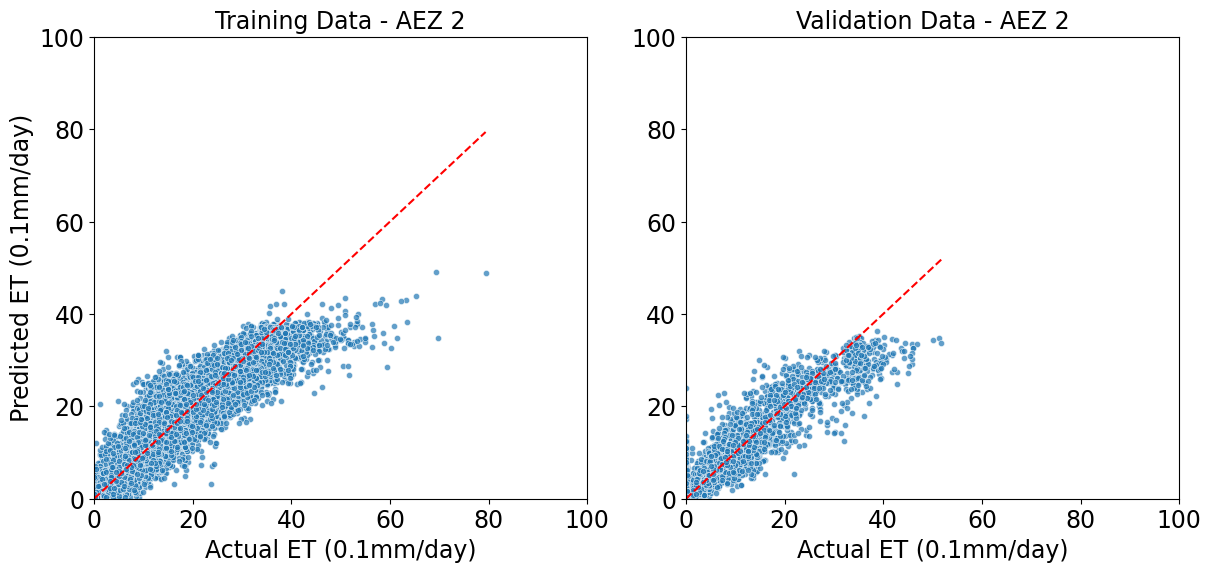

In [39]:
y_actual = y_train
aez = 2
set_fontsize = 17

# subfigure of size 2x1
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)


plt.scatter(y_actual, y_pred_train, s=20, alpha=0.7, edgecolors='w', linewidth=0.5)

# Plot the 45-degree line
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')

# Set axis labels
plt.xlim(0,100)
plt.ylim(0,100)
plt.xticks(fontsize=set_fontsize)
plt.yticks(fontsize=set_fontsize)
plt.xlabel('Actual ET (0.1mm/day)', fontsize=set_fontsize)
plt.ylabel('Predicted ET (0.1mm/day)', fontsize = set_fontsize)

# Set plot title
plt.title(f'Training Data - AEZ {aez}', fontsize=set_fontsize)

plt.subplot(1, 2, 2)

y_actual = y_test

plt.scatter(y_actual, y_pred, s=20, alpha=0.7, edgecolors='w', linewidth=0.5)

# Plot the 45-degree line
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')

# Set axis labels
plt.xlim(0,100)
plt.ylim(0,100)
plt.xticks(fontsize=set_fontsize)
plt.yticks(fontsize=set_fontsize)
plt.xlabel('Actual ET (0.1mm/day)', fontsize=set_fontsize)
# plt.ylabel('Predicted ET (0.1mm/day)', fontsize = set_fontsize)

# Set plot title
plt.title('Validation Data - AEZ 2', fontsize=set_fontsize)

plt.savefig(f'AEZ{aez}_single.png', bbox_inches='tight')
# Show the plot
plt.show()

In [270]:
print(x_test)
x_test = np.array(x_test)
indices = np.argwhere(np.isnan(x_test))
indices = np.unique(indices[:, 1])

[[ 4.55541385e-01  7.80144651e-02  2.94957200e-01 ...  0.00000000e+00
  -6.06952550e+01  2.98540700e+02]
 [ 2.18466388e-01 -7.28016866e-02  1.22631280e-01 ...  0.00000000e+00
  -7.75071260e+01  2.98094730e+02]
 [ 2.01578812e-01 -6.92555082e-02  1.12089340e-01 ...  0.00000000e+00
  -6.99285100e+01  2.98495640e+02]
 ...
 [ 2.11708660e-01 -5.39658643e-02  1.18388280e-01 ...  0.00000000e+00
  -1.69638290e+01  3.01391080e+02]
 [-6.48533471e-02  5.06615278e-01 -3.14085670e-02 ...  0.00000000e+00
  -1.54378520e+01  3.01193330e+02]
 [ 5.63072788e-01  1.93081500e-01  3.91864900e-01 ...  0.00000000e+00
  -5.20798840e+01  2.95240880e+02]]


In [272]:
print(x_test.shape)
print(y_test.shape)

# x_test = np.delete(x_test, indices, 1)
# print(x_test.shape)
# ind = np.argwhere(np.isnan(y_test))
# print(ind)

(300, 27)
(300,)


In [273]:
# Plot the scatter plot of Actual vs. Predicted (Validation Data)

y_actual = y_test
y_pred = rf_model.predict(x_test)
r2_value = r2_score(y_actual, y_pred)
set_fontsize = 17
print(f'r2_value: {r2_value}')
plt.scatter(y_actual, y_pred, s=40, alpha=0.7, linewidth=0.5)

# Plot the 45-degree line
plt.plot([0, 60], [0, 60], color='red', linestyle='--')

# Set axis labels
plt.xlim(0,80)
plt.ylim(0,80)
plt.xlabel('Actual ET (0.1mm/day)', fontsize = set_fontsize)
plt.ylabel('Predicted ET (0.1mm/day)', fontsize = set_fontsize)

# Set plot title
plt.title('Forest Region', fontsize = set_fontsize)
plt.savefig('forest-cover.png', fontsize = set_fontsize)
# Show the plot
plt.show()

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
buildup: 0.83
forest: 0.51
crop: 0.85



## 4. Uploading trained model to Google Earth Engine:
1. Serialise the random forest model to a list of strings (where each string represents a decision tree)
2. Convert the list of strings to a `ee.FeatureCollection`
3. Export the `ee.FeatureCollection` to Google Earth Engine as an asset

Serialise random forest to strings and store it in rf_strings

In [ ]:

rf_strings = ml.rf_to_strings(rf_model, feature_names, output_mode='regression', processes=6)


To convert the list of strings to a ee.FeatureCollection :
1. Convert the list of strings to a list of dummy ee.Features (with any ~NON NULL~ geometry and property `tree` set as the string representing the tree)
2. Convert this list of features to a ee.FeatureCollections and store it in fc_string

In [ ]:
dummy_feature = ee.Feature(ee.Geometry.Point([-114.318, 38.985]));
treeStrings = []
for dt in rf_strings:
  feat = dummy_feature.set('tree', dt)
  treeStrings.append(feat)
fc_string = ee.FeatureCollection(treeStrings)

Export the `ee.FeatureCollection` to earth engine asset

In [ ]:
asset_name = 'rf_demo_7'
task_name = asset_name+'_task'
asset_path= 'projects/vatsal-stiti/assets/'+asset_name
task = ee.batch.Export.table.toAsset(fc_string,task_name,asset_path);
task.start()

## 5. Downloading the Model in GEE and using it to inference ET:
To download the model from GEE asset and load it as a classifier use this code snippet in Google Earth Engine Editor:
```
var RandomForestasFeatCollection = ee.FeatureCollection(assetName).aggregate_array('tree').aside(print);
var classifier = ee.Classifier.decisionTreeEnsemble(RandomForestasFeatCollection);
```
Replace assetName with the path of asset that contains the model. The code is available in the script at: `Vatsal_Stiti/FinalPipelineScripts/InferenceETFromModelAsset`. Use this script to predict ET of any area on a given date.